In [1]:
import os  # operating system
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# print current working directory
os.getcwd()

'/Users/eranagmon/code/notebook_tests'

In [2]:
files = os.listdir('co-culture_data')
print(files)

['Bac_L species.csv', 'yeast_G candidum.csv', 'Bac_B aurantiacum.csv', 'Bac_s xylosus.csv', 'Bac_H alvei.csv', 'Yeast_Y lipolytica.csv', 'Yeast_D hassenii.csv', 'Bac_A arilaitensis.csv']


In [3]:
# put the data in one dataframe
all_dat = []
for i in range(len(files)):
    df1 = pd.read_csv('co-culture_data/' + files[i], index_col=0, header=0)
    splitnames = files[i].split('.')
    filename = splitnames[0]
    df1.rename(columns = {'logCFU': filename}, inplace=True)
    all_dat.append(df1)

df2 = pd.concat(all_dat, axis=1)
# df2

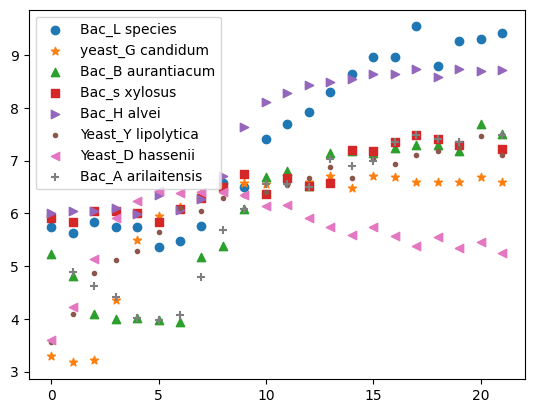

In [4]:
plt.figure()
markers = ["o", '*', '^', 's', '>', '.', '<', '+', 'v']
for i in range(len(df2.columns)):
    mi=markers[i]
    plt.scatter(df2.index, df2[f'{df2.columns[i]}'], alpha=1, marker=mi, label=f'{df2.columns[i]}')

plt.legend()
plt.show()

In [5]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# help(curve_fit)

In [6]:
species_names = ['Bac_L species', 'Bac_H alvei']  # TODO -- can get names from the dataframe to make this more scalable

In [7]:
NUM_SPECIES = len(species_names)

def generalized_lotka_volterra(t, *params):
    growth_rates = np.array(params[:NUM_SPECIES])
    interactions = np.array(params[NUM_SPECIES:]).reshape((NUM_SPECIES, NUM_SPECIES))

    def model(populations, t):
        dX = []
        for i, x in enumerate(populations):
            dx = growth_rates[i]*x
            
            interaction = 0
            for j in range(NUM_SPECIES):
                interaction += interactions[i][j]*x*populations[j]
    
            dx += interaction
            dX.append(dx)
        return dX

    solution = odeint(model, initial_populations, t)
    return solution.flatten()

In [8]:
# get the data out of the dataframe
time_data = np.array(df2.index)

# get population data
population_data = np.zeros((len(time_data), len(species_names)))
for i, species in enumerate(species_names):
    species_pop = df2[species].to_numpy()
    population_data[:,i] = species_pop

# print(f'TIMES: {time_data}')
# population_data

In [9]:
initial_populations = [6, 6]  # the inital state

guess = [1 for _ in range(NUM_SPECIES)] + [0]*(NUM_SPECIES*NUM_SPECIES)
guess

[1, 1, 0, 0, 0, 0]

### use curve_fit

In [10]:
population_data_flattened = population_data.flatten()

params, cov = curve_fit(generalized_lotka_volterra, time_data, population_data_flattened, p0=guess)

/Users/eranagmon/code/notebook_tests/venv/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/eranagmon/code/notebook_tests/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
# print the parameters
print(f"Fitted parameters: {params}")

Fitted parameters: [ 2.21693210e-02  2.11811923e-02 -5.25773481e-21  5.30594738e-61
  2.06831009e-56 -2.06825677e-56]


In [12]:
fitted_results = generalized_lotka_volterra(time_data, *params).reshape(len(time_data),NUM_SPECIES)
fitted_results

array([[6.        , 6.        ],
       [6.13450129, 6.12844261],
       [6.27201768, 6.25963481],
       [6.41261681, 6.39363549],
       [6.55636771, 6.53050472],
       [6.70334105, 6.67030392],
       [6.85360908, 6.81309582],
       [7.00724566, 6.95894448],
       [7.16432629, 7.10791535],
       [7.32492818, 7.26007524],
       [7.48913028, 7.41549246],
       [7.6570133 , 7.57423672],
       [7.82865971, 7.73637922],
       [8.00415387, 7.9019927 ],
       [8.18358205, 8.07115148],
       [8.36703247, 8.24393146],
       [8.55459529, 8.42041018],
       [8.74636268, 8.60066679],
       [8.9424289 , 8.78478218],
       [9.14289032, 8.97283894],
       [9.34784546, 9.16492146],
       [9.55739505, 9.36111591]])

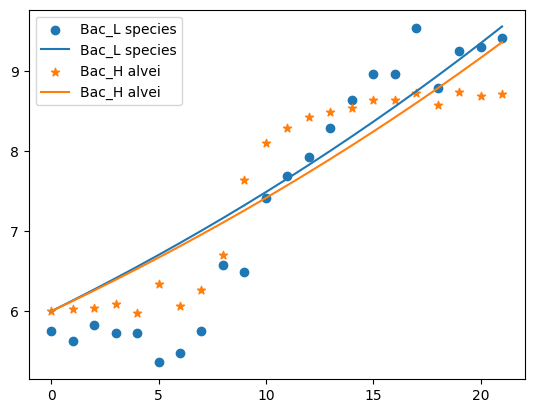

In [13]:
plt.figure()
for i in range(NUM_SPECIES):
    plt.scatter(time_data, population_data[:, i], marker=markers[i], label=species_names[i])
    plt.plot(time_data, fitted_results[:,i], label=species_names[i])

plt.legend()
plt.show()

## differential evolution optimization method

In [14]:
from scipy.optimize import differential_evolution

# Define the objective function for optimization
def objective(params, t_data, observed_data):
    # Generate model predictions
    predictions = generalized_lotka_volterra(t_data, *params)
    
    # flatten results
    predictions_flattened = predictions.flatten()

    # Calculate sum of squared differences
    ssd = np.sum((observed_data - predictions_flattened) ** 2)
    return ssd


In [15]:
# Define bounds for each parameter (growth rates and interactions)
bounds = [(-1, 1)] * NUM_SPECIES + [(-0.1, 0.1)] * (NUM_SPECIES * NUM_SPECIES)

# Perform the differential evolution optimization
result = differential_evolution(
    objective, 
    bounds, 
    args=(time_data, population_data_flattened),
    strategy='best1bin', 
    maxiter=1000, 
    popsize=15,
    tol=0.01, 
    mutation=(0.5, 1), 
    recombination=0.7
)

print("Fitted parameters:", result.x)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4030046134064D+01   r2 =  0.3958403126865D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4030046134064D+01   r2 =  0.3958403126865D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4030046134064D+01   r2 =  0.3958403126865D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4030046134064D+01   r2 =  0.3958403126865D-15
 lsoda--  warning..internal t (=r1) 

In [18]:
print(f'RESULTS: {result.x}')

RESULTS: [-0.23267806 -0.05197548 -0.06887674  0.09997175 -0.04162264  0.04933904]


### simulate with fitted params

In [16]:
fitted_results2 = generalized_lotka_volterra(time_data, *result.x).reshape(len(time_data),NUM_SPECIES)
fitted_results2

array([[6.        , 6.        ],
       [5.77337935, 5.99402096],
       [5.63625636, 6.03926781],
       [5.5774233 , 6.1302142 ],
       [5.59012949, 6.26294869],
       [5.67051714, 6.43427449],
       [5.8163869 , 6.64092589],
       [6.0260073 , 6.87880398],
       [6.29678485, 7.14221202],
       [6.62372813, 7.42316084],
       [6.99781344, 7.71092195],
       [7.40462444, 7.99210435],
       [7.82390224, 8.25153646],
       [8.23070974, 8.4740614 ],
       [8.59852189, 8.64696553],
       [8.90367383, 8.76232705],
       [9.12971425, 8.81841729],
       [9.27001436, 8.81961644],
       [9.32777643, 8.77496384],
       [9.31381195, 8.69600213],
       [9.24327058, 8.59468627],
       [9.13252447, 8.48186274]])

### plot results

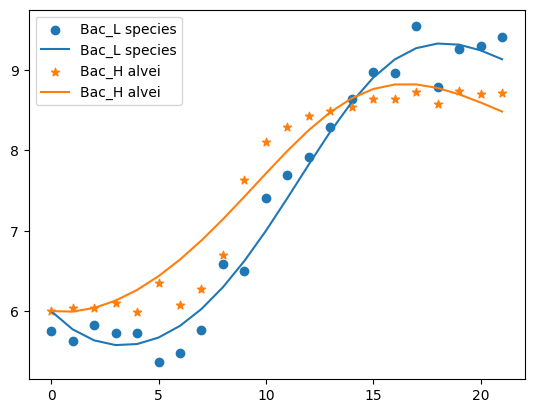

In [17]:
plt.figure()
for i in range(NUM_SPECIES):
    plt.scatter(time_data, population_data[:, i], marker=markers[i], label=species_names[i])
    plt.plot(time_data, fitted_results2[:,i], label=species_names[i])

plt.legend()
plt.show()